<a href="https://colab.research.google.com/github/sadidoll/Machine-Learning/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Most of the code is utilized from:
https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset


In [6]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import re
import graphviz
#import xgboost as xgb
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.feature_selection import RFE
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [7]:
# URLs contain the train.csv and test.csv file from the Titanic dataset
train_download = "https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_"
test_download = "https://docs.google.com/uc?export=download&id=1W6Lth3OEjzqyLg5O8U_TCT1oayebB2dE"

!wget -O train.csv --no-check-certificate "$train_download"
!wget -O test.csv --no-check-certificate "$test_download"

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

--2021-03-01 06:59:45--  https://docs.google.com/uc?export=download&id=1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_
Resolving docs.google.com (docs.google.com)... 172.217.3.46, 2607:f8b0:4026:801::200e
Connecting to docs.google.com (docs.google.com)|172.217.3.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/631dpth9m9ahhlj8trrneo8jgh162c2h/1614581925000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download [following]
--2021-03-01 06:59:45--  https://doc-00-68-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/631dpth9m9ahhlj8trrneo8jgh162c2h/1614581925000/16552832296577571015/*/1SxOK4zcBPL2C0ArlxFyLavnvEjgzjKQ_?e=download
Resolving doc-00-68-docs.googleusercontent.com (doc-00-68-docs.googleusercontent.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connecting to doc-00-68-docs.googleusercontent.com (doc-00-68-docs.googleuserc

In [8]:
# Store our test passenger IDs for easy access
PassengerId = test_df['PassengerId']

In [9]:
print(PassengerId)

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64


In [10]:
# "original_train = train" will create a reference to the train variable (changes in 'train' will apply to 'original_train')
original_train = train_df.copy() # Using 'copy()' allows to clone the dataset, creating a different object with the same values

# Feature engineering steps taken from Sina and Anisotropic, with minor changes to avoid warnings
combine = [train_df, test_df]

# Feature that tells whether a passenger had a cabin on the Titanic
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())
    
# Remove all NULLS in the Age column
for dataset in combine:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    # Next line has been improved to avoid warning
    dataset.loc[np.isnan(dataset['Age']), 'Age'] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for dataset in combine:
    dataset['Title'] = dataset['Name'].apply(get_title)

In [11]:
# Group all non-common titles into one single grouping "Rare"
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don',
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in combine:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Master": 2, "Mrs": 3, "Miss": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] ;

# After analyzing the dataset, we remove the features which we no longer required (Feature Selection):

In [12]:
# Drops the 'Ticket' feature for the training and test sets, as well as the
# 'PassengerId' and 'Name' features, which doesn't help with determining
# survival
train_df = train_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin','SibSp'], axis=1)
test_df = test_df.drop(['PassengerId', 'Name', 'Ticket','Cabin','SibSp'], axis=1)

## As we can see below our Titanic Training & Test dataset only have numerical values including important features that will help us determine the survival:

In [13]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,0,2,0,1
1,1,1,0,2,0,3,1,1,2,0,3
2,1,3,0,1,0,1,0,0,1,1,4
3,1,1,0,2,0,3,0,1,2,0,3
4,0,3,1,2,0,1,0,0,1,1,1


In [14]:
test_df.head(5)

,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,0,1,1,1
1,3,0,2,0,0,0,0,2,0,3
2,2,1,3,0,1,2,0,1,1,1
3,3,1,1,0,1,0,0,1,1,1
4,3,0,1,1,1,0,0,3,0,3


In [15]:
train_df.corr('pearson')

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Has_Cabin,FamilySize,IsAlone,Title
Survived,1.000000,-0.338481,-0.543351,-0.067878,0.081629,0.295875,0.106811,0.316912,0.016639,-0.203367,0.492031
Pclass,-0.338481,1.000000,0.131900,-0.112238,0.018443,-0.628459,0.045702,-0.725541,0.065997,0.135207,-0.165849
Sex,-0.543351,0.131900,1.000000,0.087590,-0.245489,-0.248940,-0.116569,-0.140391,-0.200988,0.303646,-0.859084
Age,-0.067878,-0.112238,0.087590,1.000000,-0.042386,0.019703,0.041544,0.083597,-0.065792,0.063467,-0.065170
Parch,0.081629,0.018443,-0.245489,-0.042386,1.000000,0.393048,-0.078665,0.036987,0.783111,-0.583398,0.221987
Fare,0.295875,-0.628459,-0.248940,0.019703,0.393048,1.000000,-0.091096,0.497108,0.465815,-0.568942,0.252631
Embarked,0.106811,0.045702,-0.116569,0.041544,-0.078665,-0.091096,1.000000,0.013774,-0.080281,0.017807,0.142480
Has_Cabin,0.316912,-0.725541,-0.140391,0.083597,0.036987,0.497108,0.013774,1.000000,-0.009175,-0.158029,0.138106
FamilySize,0.016639,0.065997,-0.200988,-0.065792,0.783111,0.465815,-0.080281,-0.009175,1.000000,-0.690922,0.213570
IsAlone,-0.203367,0.135207,0.303646,0.063467,-0.583398,-0.568942,0.017807,-0.158029,-0.690922,1.000000,-0.259345


## This heatmap of correlation is important as it allows us to know which features are the most important ones. Whiel creating Decision tree, there are high chances that either Sex or Title will be used as root or first node.

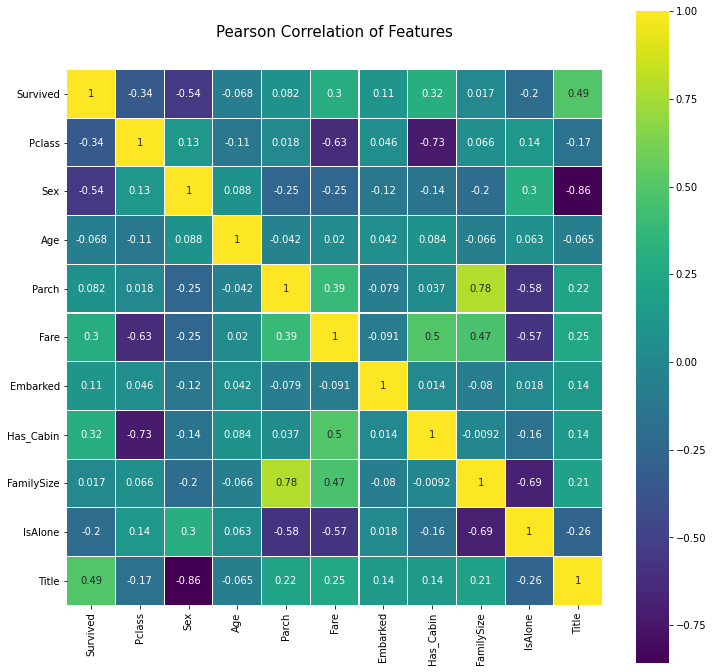

In [16]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

## Female = 0 and Male = 1

In [17]:
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
         mean count  sum
Sex                     
0    0.742038   314  233
1    0.188908   577  109

In [18]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).agg(['mean', 'count', 'sum'])

Survived           
           mean count  sum
Title                     
1      0.156673   517   81
2      0.575000    40   23
3      0.793651   126  100
4      0.702703   185  130
5      0.347826    23    8

## Defining Gini.
Reference: 
https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset 

In [19]:
# Define function to calculate Gini Impurity
def get_gini_impurity(survived_count, total_count):
    survival_prob = survived_count/total_count
    not_survival_prob = (1 - survival_prob)
    random_observation_survived_prob = survival_prob
    random_observation_not_survived_prob = (1 - random_observation_survived_prob)
    mislabelling_survided_prob = not_survival_prob * random_observation_survived_prob
    mislabelling_not_survided_prob = survival_prob * random_observation_not_survived_prob
    gini_impurity = mislabelling_survided_prob + mislabelling_not_survided_prob
    return gini_impurity

## We need to know if we have to Split for Title or Sex feature there we will calculate the overall weighted Gini Impurity:

In [20]:
# Gini Impurity of starting node, (342 -> survival count see above code and 891 is the total)
gini_impurity_starting_node = get_gini_impurity(342, 891)
gini_impurity_starting_node

0.47301295786144265

In [21]:
# Gini Impurity decrease of node for 'male' observations
gini_impurity_men = get_gini_impurity(109, 577)
gini_impurity_men

0.3064437162277843

In [22]:
# Gini Impurity decrease if node splited for 'female' observations
gini_impurity_women = get_gini_impurity(233, 314)
gini_impurity_women

0.3828350034484158

In [23]:
# Gini Impurity decrease if node splited by Sex
men_weight = 577/891
women_weight = 314/891
weighted_gini_impurity_sex_split = (gini_impurity_men * men_weight) + (gini_impurity_women * women_weight)

sex_gini_decrease = weighted_gini_impurity_sex_split - gini_impurity_starting_node
sex_gini_decrease

-0.13964795747285214

In [24]:
# Gini Impurity decrease of node for observations with Title : Mr
gini_impurity_title_1 = get_gini_impurity(81, 517)
gini_impurity_title_1

0.26425329886377663

In [25]:
# Gini Impurity decrease if node splited for observations with Title != 1 != Mr
gini_impurity_title_others = get_gini_impurity(261, 374)
gini_impurity_title_others

0.42170207898424317

In [26]:
# Gini Impurity decrease if node splited for observations with Title == 1 == Mr
title_1_weight = 517/891
title_others_weight = 374/891
weighted_gini_impurity_title_split = (gini_impurity_title_1 * title_1_weight) + (gini_impurity_title_others * title_others_weight)

title_gini_decrease = weighted_gini_impurity_title_split - gini_impurity_starting_node
title_gini_decrease

-0.14267004758907514

## From the calculation above, Title feature is better at reducing the Gini Impurity than Sex feature. Therefore we will use Title feature to split.

## We use 5 folds as the questions ask to:

In [27]:
cv = KFold(n_splits=5)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test_df))
depth_range = range(1, max_attributes + 1)

# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    for train_fold, valid_fold in cv.split(train_df):
        f_train = train_df.loc[train_fold] # Extract train data with cv indices
        f_valid = train_df.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    print("Accuracy per fold: ", fold_accuracy, "\n")
    print("Average accuracy: ", avg)
    
# show results
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

Accuracy per fold:  [0.770949720670391, 0.8033707865168539, 0.7865168539325843, 0.7359550561797753, 0.797752808988764] 

Average accuracy:  0.7789090452576737
Accuracy per fold:  [0.770949720670391, 0.8033707865168539, 0.8146067415730337, 0.7359550561797753, 0.8146067415730337] 

Average accuracy:  0.7878978093026174
Accuracy per fold:  [0.8547486033519553, 0.8146067415730337, 0.8202247191011236, 0.7865168539325843, 0.8651685393258427] 

Average accuracy:  0.828253091456908
Accuracy per fold:  [0.8547486033519553, 0.8033707865168539, 0.8258426966292135, 0.7921348314606742, 0.8707865168539326] 

Average accuracy:  0.8293766869625261
Accuracy per fold:  [0.770949720670391, 0.797752808988764, 0.8202247191011236, 0.7696629213483146, 0.8820224719101124] 

Average accuracy:  0.8081225284037412
Accuracy per fold:  [0.8044692737430168, 0.797752808988764, 0.848314606741573, 0.7808988764044944, 0.848314606741573] 

Average accuracy:  0.8159500345238841
Accuracy per fold:  [0.7877094972067039, 0.

In [28]:
# Code to check available fonts and respective paths
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

['/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf',
 '/usr/share/fonts/truetype/libera

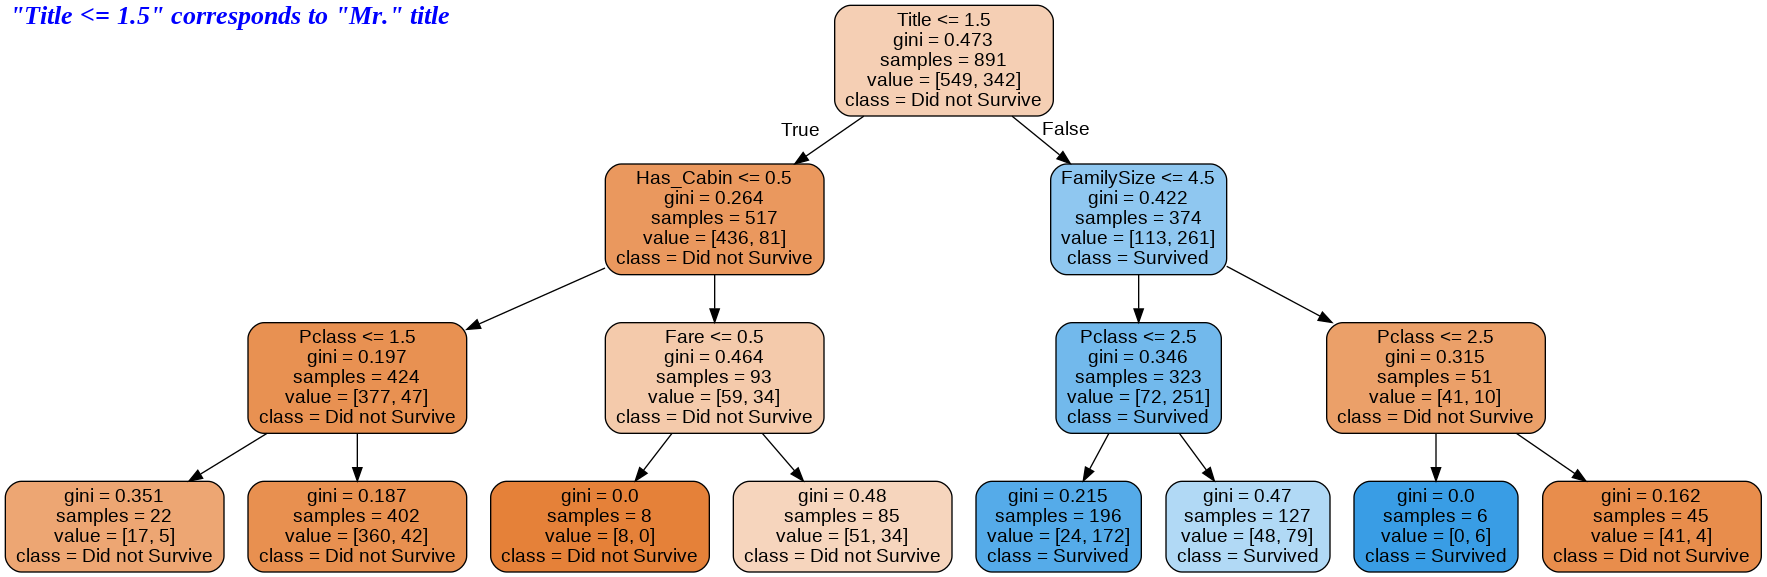

In [29]:
## Reference TAken from : https://www.kaggle.com/dmilla/introduction-to-decision-trees-titanic-dataset
# Create Numpy arrays of train, test and target (Survived) dataframes to feed into our models
y_train = train_df['Survived']
x_train = train_df.drop(['Survived'], axis=1).values 
x_test = test_df.values

# Create Decision Tree with max_depth = 3(High accuray : 82.8%)
decision_tree = tree.DecisionTreeClassifier(max_depth = 3)
decision_tree.fit(x_train, y_train)

# Predicting results for test dataset
y_pred = decision_tree.predict(x_test)
submission = pd.DataFrame({
        "PassengerId": PassengerId,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index=False)

# Export our trained model as a .dot file
with open("tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 3,
                              impurity = True,
                              feature_names = list(train_df.drop(['Survived'], axis=1)),
                              class_names = ['Did not Survive', 'Survived'],
                              rounded = True,
                              filled= True )
        
#Convert .dot to .png to allow display in web notebook
check_call(['dot','-Tpng','tree1.dot','-o','tree1.png'])

# Annotating chart with PIL
img = Image.open("tree1.png")
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSerif-BoldItalic.ttf', 26)
draw.text((10, 0), # Drawing offset (position)
          '"Title <= 1.5" corresponds to "Mr." title', # Text to draw
          (0,0,255), # RGB desired color
          font=font) # ImageFont object with desired font
img.save('sample-out.png')
PImage("sample-out.png")

## Average Classification accuracy:

In [30]:
avg_acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
avg_acc_decision_tree

82.38

# Random Forest

In [31]:
##random_forest = RandomForestClassifier(n_estimators=100)
##random_forest.fit(x_train, y_train)

##y_pred = random_forest.predict(x_test)

##random_forest.score(x_train, y_train)
#acc_random_forest = round(random_forest.score(x_train, y_train) * 100, 2)
#acc_random_forest

In [32]:
cv = KFold(n_splits=5)            # Desired number of Cross Validation folds
accuracies = list()
max_attributes = len(list(test_df))
##depth_range = range(1, max_attributes + 1)
n_estimators = [10,50, 100, 150, 200, 250, 300, 350]
# Testing max_depths from 1 to max attributes
# Uncomment prints for details about each Cross Validation pass
for depth in n_estimators:
    fold_accuracy = []
    ##tree_model = tree.DecisionTreeClassifier(max_depth = depth)
    tree_model = ensemble.RandomForestClassifier(n_estimators = depth)
    for train_fold, valid_fold in cv.split(train_df):
        f_train = train_df.loc[train_fold] # Extract train data with cv indices
        f_valid = train_df.loc[valid_fold] # Extract valid data with cv indices

        model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                               y = f_train["Survived"]) # We fit the model with the fold train data
        valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                                y = f_valid["Survived"])# We calculate accuracy with the fold validation data
        fold_accuracy.append(valid_acc)

    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# show results
df = pd.DataFrame({"n_estimators": n_estimators, "Average Accuracy": accuracies})
df = df[["n_estimators", "Average Accuracy"]]
print(df.to_string(index=False))

 n_estimators  Average Accuracy
           10          0.815969
           50          0.819315
          100          0.815950
          150          0.818204
          200          0.813697
          250          0.815944
          300          0.810326
          350          0.812604


In [33]:
#y_train = train_df['Survived']
#x_train = train_df.drop(['Survived'], axis=1).values 
#x_test = test_df.values

# Create Decision Tree with max_depth 
random_tree = ensemble.RandomForestClassifier(n_estimators = 300)
random_tree.fit(x_train, y_train)
y_pred = random_tree.predict(x_test)

avg_acc_random_tree = round(random_tree.score(x_train, y_train) * 100, 2)
avg_acc_random_tree

90.01

In [34]:
results = pd.DataFrame({
    'Model': [ 'Random Forest',  
              'Decision Tree'],
    'Score': [avg_acc_random_tree,avg_acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
90.01,Random Forest
82.38,Decision Tree


#Five-fold cross validation classification accuracies on Titanic training set, with respect to the linear, quadratic, and RBF kernels

In [52]:
from sklearn.model_selection import train_test_split #for split the data
from sklearn.model_selection import KFold
from sklearn import svm 
from sklearn import metrics #accuracy measure

In [50]:
y_train = train_df['Survived']
x_train = train_df.drop(['Survived'], axis=1).values 
x_test = test_df.values

In [46]:
kfold = KFold(n_splits=5)

In [54]:
model=svm.SVC(kernel='linear',C=0.1,gamma=0.1)
model.fit(x_train,y_train)
prediction1=model.predict(x_test)
print('Accuracy for linear SVM is ',metrics.accuracy_score(prediction1,y_pred))

Accuracy for linear SVM is  0.8325358851674641


In [55]:
model=svm.SVC(kernel='rbf',C=1,gamma=0.1,random_state=0)
model.fit(x_train,y_train)
prediction2=model.predict(x_test)
print('Accuracy for rbf SVM is ',metrics.accuracy_score(prediction2,y_pred))

Accuracy for rbf SVM is  0.868421052631579


In [56]:
model=svm.SVC(kernel='poly',degree = 2, random_state=0)
model.fit(x_train,y_train)
prediction2=model.predict(x_test)
print('Accuracy for quad SVM is ',metrics.accuracy_score(prediction2,y_pred))

Accuracy for quad SVM is  0.8349282296650717


In [57]:
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=5, random_state=22) # k=5, split the data into 5 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Poly Svm']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),svm.SVC(kernel='poly',degree= 2)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
new_models_dataframe2

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning:

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.



,CV Mean,Std
Linear Svm,0.788965,0.029432
Radial Svm,0.790101,0.016383
Poly Svm,0.775519,0.018613


**As we can see above the Radial Svm that is RBF kernal function works the best**